# Deep Unfolding
In this notebook we will compare the iterative soft thresholding algorithm (ISTA) to its deep unfolded version, coined learned ISTA (LISTA). LISTA is in fact the origin of deep unfolding methodology, proposed by Gregor and LeCun back in 2010, and has spurred a multitude of variants over the years. This notebook compares a basic implementation of it to the model-based ISTA, examining the ability of deep unfolding to increase the convergence rate of iterative optimizers.


In [1]:
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data


from plots import plot_admm_vs_ladmm_reconstruction, plot_admm_vs_ladmm_convergence, plot_observation

torch.manual_seed(0)

torch.set_default_dtype(torch.float64)

## Data
Next, we generate a data set $\mathcal{D}=\{(\boldsymbol{s}_t, \boldsymbol{x}_t)\}_{t=1}^{n_t}$, where each $\boldsymbol{s}_t$ has $m=200$ entries, out of which at most $k=4$ are non-zero, while $\boldsymbol{x}_t$ has $n=150$ entires and is obtained via
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{H}\boldsymbol{s}_t + \boldsymbol{w}_t,
\end{equation}
with $\boldsymbol{w}_t$ being i.i.d. Gaussian noise.

To that aim, we generate a dedicated class inheriting Dataset to get the data samples, and to allow each tuple to be comprised of both $(\boldsymbol{s}_t, \boldsymbol{x}_t)$ as well as $\boldsymbol{H}$.

In [ ]:
class SimulatedData(Data.Dataset):
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        x = self.x[:, idx]
        H = self.H
        s = self.s[:, idx]
        return x, H, s




The next function creates a dataset.

In [ ]:
def create_data_set(H, n, m, k, N=1000, batch_size=512, snr=30, noise_dev=0.5):
    # Initialization

    x = torch.zeros(n, N)
    s = torch.zeros(m, N)
    # Create signals
    for i in range(N):
        # Create a sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = noise_dev * np.random.randn(k)

        s[index_k, i] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[:, i] = H @ s[:, i] + 0.01 * np.random.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

Finally, we generate the data set

In [2]:
n, m, k = 150, 200, 4

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

train_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

test_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

Let's see what the samples look like


In [ ]:
x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plot_observation(x_exm, s_exm)

Vanilla ADMM implementation

In [3]:
def vanilla_admm(x, H, lambda_=12.5, mu=0.00005, rho=0.01, max_itr=300, eps=10 ** -5):
    proj = torch.nn.Softshrink(rho / (2 * lambda_))

    # initial estimate
    s = torch.zeros((H.shape[1]))
    u = torch.zeros((H.shape[1]))
    v = torch.zeros((H.shape[1]))

    # left_term = (H^TH+2λI)^-1 2*lambda or rho?
    left_term = torch.linalg.inv(H.T @ H + rho * torch.eye(H.shape[1]))

    recovery_errors = []
    for k in range(max_itr):
        s_prev, v_prev, u_prev = s, v, u

        # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).

        right_term = H.T @ x + rho * (v_prev - u_prev)
        s = left_term @ right_term

        # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
        v = proj(s + u_prev)

        # Update uk+1 = uk + μ (sk+1 − vk+1).

        u = u_prev + mu * (s - v)

        # # cease if convergence achieved
        if torch.sum(torch.abs(s - s_prev)) <= eps:
            break

        # save recovery error
        recovery_errors.append(torch.sum((torch.matmul(H, s) - x) ** 2))

    return s

Model Based ADMM implementation

In [4]:
class LADMM_Model(nn.Module):
    def __init__(self, n, m, T=6, rho=0.01, H=None, lambda_=12.5, mu=0.00005):
        super(LADMM_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H

        # ISTA Iterations
        self.T = T

        # Initialization
        self.rho = nn.Parameter(torch.ones(T + 1, 1, 1) * rho, requires_grad=True) # Lagrangian Multiplier
        self.lambda_ = nn.Parameter(torch.ones(T + 1, 1, 1) * lambda_, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1) * mu, requires_grad=True)

    def _shrink(self, s, beta, rho):
        return beta * F.softshrink(s / beta, lambd=rho)

    def forward(self, x):
        """

        Args:
            x: a sparse signal observation
        Returns: S reconstruction
        """
        # H.shape[1] = 200, x.shape[0[ = 512 (batch size)
        # s_prev = torch.zeros(x.shape[0], self.H.shape[1])
        u_prev = torch.zeros((x.shape[0], self.H.shape[1]))
        v_prev = torch.zeros((x.shape[0], self.H.shape[1]))

        #################### Iteration 0 ####################

        #TODO NIR left_term = (H^TH+2λI)^-1 2*lambda or rho?
        left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[0, :, :] * torch.eye(self.H.shape[1]))

        right_term = (self.H.T @ x.T).T + self.rho[0, :, :] * (v_prev - u_prev)

        s = (left_term @ right_term.T).T
        v = self._shrink(s + u_prev,
                         self.rho[0, :, :] / (2 * self.lambda_[0, :, :]),
                         rho=self.rho[0, :, :].item())
        u = u_prev + self.mu[0, :, :] * (s - v)

        #################### Iteration 1<=i<=K ####################

        for i in range(1, self.T + 1):
            s_prev, v_prev, u_prev = s, v, u

            # left_term = (H^TH+2λI)^-1 2*lambda or rho?
            left_term = torch.linalg.inv(self.H.T @ self.H + self.rho[i, :, :] * torch.eye(self.H.shape[1]))

            right_term = (self.H.T @ x.T).T + self.rho[i, :, :] * (v_prev - u_prev)

            # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).
            s = (left_term @ right_term.T).T

            # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
            v = self._shrink(s + u_prev, self.rho[i, :, :] / (2 * self.lambda_[i, :, :]), rho=self.rho[i, :, :].item())

            # Update uk+1 = uk + μ (sk+1 − vk+1).
            u = u_prev + self.mu[i, :, :] * (s - v)

        return s

## Train and Validation

For training, we use SGDM with learning rate scheduler and the $\ell_2$ loss

In [5]:
def train(model, train_loader, valid_loader, num_epochs=60):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

The following functions apply L-ADMM and ADMM for given data sets


In [6]:
def ladmm_apply(train_loader, test_loader, T, H):
    n = H.shape[1]
    m = H.shape[1]

    ladmm = LADMM_Model(n=n, m=m, T=T, H=H)

    loss_test, b_x, b_s = train(ladmm, train_loader, test_loader)
    err_list = loss_test[-1]

    return err_list, ladmm, b_x, b_s


def admm_apply(test_loader, T, H):

    loss = 0

    for step, (x, _, s) in enumerate(test_loader.dataset):
        s_hat = vanilla_admm(x=x, H=H, max_itr=T)
        loss += F.mse_loss(s_hat, s, reduction="sum").data.item()

    return loss / len(test_loader.dataset)

## Comparing L-ADMM to ADMM
Finally, we show that by learning the parameterization of ADMM in a per-iteration manner, one can notably imporve its convergence rate. To that aim, in the following loop we compare ISTA to trained LISTA with different number of iterations.

Epoch 0, Train loss 0.29178745, Validation loss 0.28367185
Epoch 10, Train loss 0.29128425, Validation loss 0.28337120
Epoch 20, Train loss 0.29105957, Validation loss 0.28337400
Epoch 30, Train loss 0.29105878, Validation loss 0.28336347
Epoch 40, Train loss 0.29103577, Validation loss 0.28336378
Epoch 50, Train loss 0.29104216, Validation loss 0.28336519


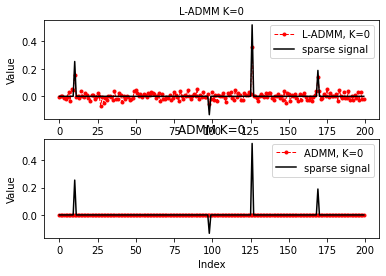

Epoch 0, Train loss 0.29825131, Validation loss 0.29060819
Epoch 10, Train loss 0.28195500, Validation loss 0.27271494
Epoch 20, Train loss 0.23720322, Validation loss 0.22410078
Epoch 30, Train loss 0.12939152, Validation loss 0.11803029
Epoch 40, Train loss 0.07659012, Validation loss 0.07202530
Epoch 50, Train loss 0.06147855, Validation loss 0.05883321


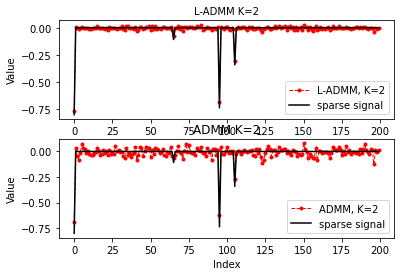

Epoch 0, Train loss 0.29845225, Validation loss 0.29090336
Epoch 10, Train loss 0.29738639, Validation loss 0.28956420
Epoch 20, Train loss 0.27800113, Validation loss 0.26722532
Epoch 30, Train loss 0.18506017, Validation loss 0.16854260
Epoch 40, Train loss 0.06350020, Validation loss 0.05602213
Epoch 50, Train loss 0.03400257, Validation loss 0.03190245


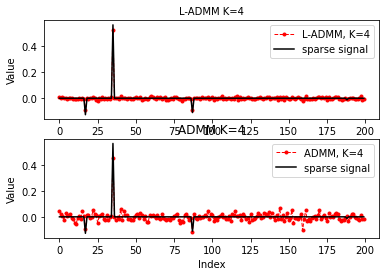

Epoch 0, Train loss 0.29840503, Validation loss 0.29085665
Epoch 10, Train loss 0.29772092, Validation loss 0.29004975
Epoch 20, Train loss 0.29071291, Validation loss 0.28184055
Epoch 30, Train loss 0.23256924, Validation loss 0.21723642
Epoch 40, Train loss 0.08173787, Validation loss 0.06969145
Epoch 50, Train loss 0.02568368, Validation loss 0.02374078


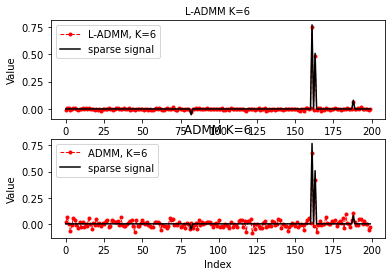

Epoch 0, Train loss 0.29834747, Validation loss 0.29079820
Epoch 10, Train loss 0.29749718, Validation loss 0.28980372
Epoch 20, Train loss 0.29041004, Validation loss 0.28167892
Epoch 30, Train loss 0.23716539, Validation loss 0.22213693
Epoch 40, Train loss 0.08183627, Validation loss 0.06900926
Epoch 50, Train loss 0.02078265, Validation loss 0.01906174


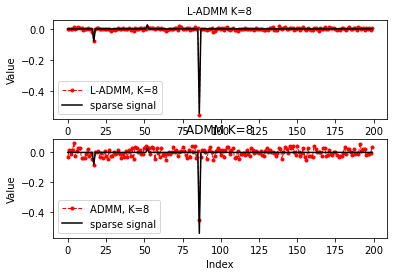

Epoch 0, Train loss 0.29828940, Validation loss 0.29073920
Epoch 10, Train loss 0.29724128, Validation loss 0.28951365
Epoch 20, Train loss 0.28895471, Validation loss 0.28008379
Epoch 30, Train loss 0.23305358, Validation loss 0.21780898
Epoch 40, Train loss 0.07674228, Validation loss 0.06438282
Epoch 50, Train loss 0.01805314, Validation loss 0.01651207


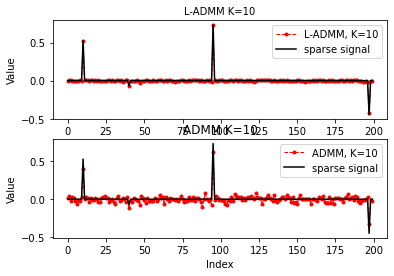

Epoch 0, Train loss 0.29823132, Validation loss 0.29068013
Epoch 10, Train loss 0.29698018, Validation loss 0.28921730
Epoch 20, Train loss 0.28729601, Validation loss 0.27822850
Epoch 30, Train loss 0.22673593, Validation loss 0.21134042
Epoch 40, Train loss 0.07173939, Validation loss 0.06009968
Epoch 50, Train loss 0.01669821, Validation loss 0.01527753


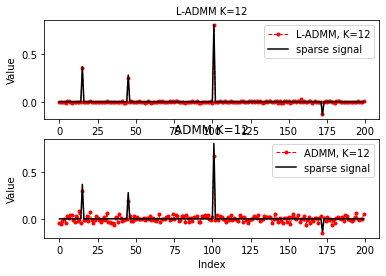

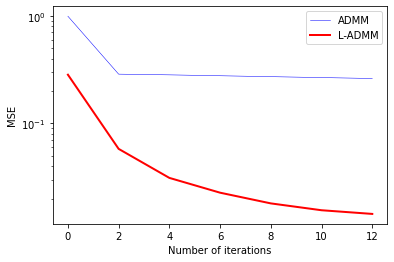

In [7]:

# Number of unfoldings
tstart, tend, tstep = 0, 13, 2
T_opt = range(tstart, tend, tstep)

admm_mse = []
ladmm_mse = []

for i, T in enumerate(T_opt):

    # Train and apply model based ADMM
    err_lst, k_l_admm, b_x, b_s = ladmm_apply(train_loader, test_loader, T, H)
    ladmm_mse.append(err_lst)

    # Apply vanilla ADMM
    admm_mse.append(admm_apply(test_loader, T, H))

    ######################### Visualization #########################

    # Visualize performance of a single signal from the validation batches b_x, b_s
    b_x, s_gt = b_x[0], b_s[0]

    s_hat_ladmm = k_l_admm(b_x)
    s_hat_ladmm = s_hat_ladmm.detach().numpy()[0]

    s_hat_admm = vanilla_admm(x=b_x, H=H, max_itr=T)

    plot_admm_vs_ladmm_reconstruction(s_hat_admm=s_hat_admm,
                                      s_hat_ladmm=s_hat_ladmm, T=k_l_admm.T, s_gt=s_gt)


plot_admm_vs_ladmm_convergence(T_opt,admm_mse, ladmm_mse)

